# Collisions

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import gridspec
#from celluloid import Camera
import scipy.signal as scs 
import scipy.special as ssp
from operator import add
import random
import numpy as np
import math
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from collections import deque
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
import scipy.interpolate as intp
import statistics as stat
import random
from functools import partial
from operator import eq
from itertools import zip_longest, compress, count, islice
#from labellines import labelLine, labelLines
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d


np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

## Simulation Parameters

In [2]:
nLat = 8192
nTime = 256
nSims = 10000
lSim = 3000
step = 1000
splitdata = np.arange(lSim, nSims+1, step); print('splitdata ', splitdata)

lamb = 1.5; print('lamb = ', lamb)
phi0 = 2*np.pi/6.6; print('phi0 = ', phi0)
nu = 2.*10**(-3)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 8 * 0.5 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
phi_initial = np.pi

nyq = nLat//2+1; spec = nyq//16; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 16.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)
tTime = nTime - int(2./np.sqrt(m2eff)/dtout); print('tTime =', tTime)
tcheck = int(1./np.sqrt(m2eff)/dtout); print('tcheck =', tcheck)

splitdata  [ 3000  4000  5000  6000  7000  8000  9000 10000]
lamb =  1.5
phi0 =  0.9519977738150889
m2eff =  0.01
lenLat =  3162.2776601683795
dx, dk, spec  0.3860202221885229 0.0019869176531592202 256
dtout/dt =  32.0
light_cone =  2
tTime = 231
tcheck = 12


## Extract Data from Simulations 

In [3]:
titles = [r'$\phi(x)$', r'$\partial_t \phi(x)$', r'$|\nabla \phi(x)|^2$', r'$V(\phi(x))$']
plots_file = '/home/dpirvu/big_plot_file/new_bubble_correlations/'
titles = [r'$\phi(x)$', r'$\partial_t \phi(x)$', r'$|\nabla \phi(x)|^2$', r'$V(\phi(x))$']
instanton_location = '/home/dpirvu/inst/instantons/dev/bubcorr_instanton_sim.dat'
suffix = '_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)
pickle_location = '/home/dpirvu/pickle_location/new_bubble_correlations/phi0'+str(int(20*np.pi/phi0))+'_lambda'+str(int(10*lamb))+'/'

def sim_location(sim):
    return '/gpfs/dpirvu/bubble_correlations/t'+str(nTime)+'_x'+str(nLat)+'_len{:.4f}'.format(lenLat)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_alph{:.4f}'.format(alpha)+'_spec'+str(spec)+'_sim'+str(sim)+'_fields.dat'
def positive_data_file(minSim, maxSim, multiplier, filter):
    return pickle_location+'positive_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'
def negative_data_file(minSim, maxSim, multiplier, filter):
    return pickle_location+'negative_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'

def sim_suffix(col, x, y, lag, sim):
    return '_col'+str(col)+'_lag'+str(lag)+'_width{:.3f}'.format(x)+'_amp{:.3f}'.format(y)+'_t'+str(nTime)+'_x'+str(nLat)+'_sim'+str(sim)+'_fields'

def fft_sim_location(x, y, lag, sim):
    """ x = width, y = amplitude """
    return '/gpfs/dpirvu/collisions/small_fluct_t'+str(nTime)+'_x'+str(nLat)+'_width{:.8f}'.format(x)+'_amp{:.8f}'.format(y)+'_lag'+str(lag)+'_sim'+str(sim)+'_fft_fields.dat'

def fft_sim_suffix(col, x, y, lag, sim):
    return '_col'+str(col)+'_lag'+str(lag)+'_width{:.3f}'.format(x)+'_amp{:.3f}'.format(y)+'_t'+str(nTime)+'_x'+str(nLat)+'_sim'+str(sim)+'_fft_fields'

def extract_data(filename, col):
    infile = open(filename,'r')
    lines = infile.readlines()
    field_values = [float(line.split()[col]) for line in lines[2:]]
    infile.close()
    return field_values

def complex_converter(txt):
    ii, jj = np.safe_eval(txt)
    return np.complex(ii, jj)

def extract_fft_data(filename, col):
    infile = open(filename,'r')
    lines = infile.readlines()
    str_values = [line.split()[col] for line in lines[2:]]
    complex_values = [complex_converter(str_values[i]) for i in range(len(str_values))]
    infile.close()
    return complex_values

def truncateNum(num, decimal_places):
    StrNum = str(num)
    p = StrNum.find(".") + 1 + decimal_places
    return ( StrNum[0:p] )

def simulation(col, x, y, lag, sim):
    simulation = extract_data(sim_location(x, y, lag, sim), col)
    return np.reshape(simulation, (nTime, nLat))

filter_size1 =  50.64719566216843
filter_size2 =  11.768329733973772


Text(0, 0.5, '$\\phi$')

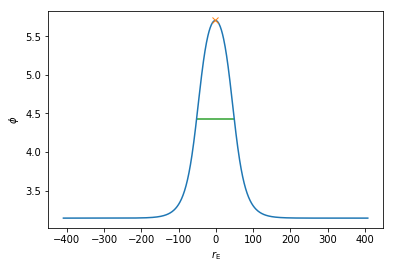

In [4]:
a = np.genfromtxt(instanton_location)
coleman_profile = np.pi+a[:,0]
xoffset = nLat//20
temp = coleman_profile[len(coleman_profile)//2-xoffset:len(coleman_profile)//2+xoffset]
peaks, _ = scs.find_peaks(temp)
fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)
filter_size1 = max(fwhm)/2.; print('filter_size1 = ', filter_size1)
filter_size2 = 4.542813258696356/dx; print('filter_size2 = ', filter_size2)
#radius_Coleman_bubble = filter_size*dx; print('radius_Coleman_bubble = ', radius_Coleman_bubble)

plt.plot(np.arange(len(temp))-xoffset, temp)
plt.plot(peaks-xoffset, temp[peaks], "x")
[plt.hlines(height[i], left_ips[i]-xoffset, right_ips[i]-xoffset, color="C2") for i in range(len(fwhm))]
plt.xlabel(r'$r_{\rm E}$'); plt.ylabel(r'$\phi$')

In [5]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))


In [6]:
tableau1 = [(50, 162, 81), (172,217,141), (255,127,15), (255,185,119), (60,183,204), (152,217,228), (184,90,13), (255,217,74), (57,115,124), (134,180,169), (130,133,59), (204,201,77)]
for i in range(len(tableau1)):
    r, g, b = tableau1[i]    
    tableau1[i] = (r / 255., g / 255., b / 255.)

tableau2 = [(44,105,176), (181,200,226), (240,39,32), (255,182,176), (172,97,60), (233,195,155), (107,163,214), (181,223,253), (172,135,99), (221,201,180), (189,10,54), (244,115,122)]
for i in range(len(tableau2)):
    r, g, b = tableau2[i]    
    tableau2[i] = (r / 255., g / 255., b / 255.)

hex_list = ["dd041d","f45b69","f6e8ea","67a9cf","0a2463"][::-1]

def hex_to_rgb(value):
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    return [v/256 for v in value]

def get_continuous_cmap(hlist):
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hlist]
    float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [7]:
def plot_data_from_files(sim):
    fig = plt.figure(figsize=(10, 5))
    tableau = all_data[sim]
    im = plt.imshow(tableau, aspect='auto', origin='lower')
    plt.colorbar(im); plt.show()
    return

def plot_potential(x, y, lag, sim):
    field = simulation(2, x, y, lag, sim)
    potential = simulation(4, x, y, lag, sim)
    plt.figure(figsize=(5,5))
    plt.plot([field[i] for i in range(nTime)], [potential[i] for i in range(nTime)], 'ko')
    plt.plot(field[-1], potential[-1], 'ro', label='t = '+str(nTime))
    plt.plot(field[80], potential[80], 'bo', label='t = 80')
    plt.plot(field[58], potential[58], 'yo', label='t = 58')
    plt.plot(field[0], potential[0], 'go', label='t = 0')
    plt.plot(np.mean(field[0]), np.mean(potential[0]), 's', color='lime')
    plt.plot(np.mean(field[-1]), np.mean(potential[-1]), 'v', color='orangered')
    plt.plot(xlabel=titles[2], ylabel=titles[4])
    plt.title('wid = {:.3f}'.format(x)+', amp = {:.3f}'.format(y)+', lag = '+str(lag)+', sim = '+str(sim))
    plt.grid(); plt.legend(); plt.show()
#    plt.savefig(field_plots + 'potential' + sim_suffix(col, x, y, lag, sim) + '.png')
    return

def plot_window_from_files(col, x, y, lag, sim):
    DATA = all_data[sim]
    nTime = len(DATA)
    field = DATA[int(nTime/2.) : int(nTime-(tean2-tean1)/2.), int(mean1) : int(mean2)]

    plt.figure(figsize=(5, 5))
    im = plt.imshow(field, aspect='auto', origin='lower', extent=[int(mean1), int(mean2), int(nTime/2.), int(nTime-(tean2-tean1)/2.)])
    plt.colorbar(im); plt.show()
#    plt.savefig(field_plots + 'window_on_field' + sim_suffix(col, x, y, lag, sim) + '.png')
    return

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

def plot_slices(sim, i, j, t, filter):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    tabl = cycle((tableau1[::]))
    line = cycle(('solid', 'dashed', 'dashdot', 'dotted'))
    i0 = i
    for slice in all_data[sim][i:j:t]:
        slice = gaussian_filter1d(slice, sigma=filter, mode='wrap')
        plt.plot(np.sqrt(4*nu)*dx*np.arange(len(slice)), slice, label=r'$\bar{t} = $'+str((i0-i)//t+1), color=next(tabl), linestyle=next(line))
        i0 = i0 + t
#    labelLines(plt.gca().get_lines(), xvals=(2*len(slice)/3, len(slice)), align=False)
    plt.grid(alpha=0.8, linestyle='dashed', linewidth=0.5)
    plt.legend(); plt.xlabel( r'$\phi_0^{-1} \sqrt{V_0} \; r$'); plt.ylabel(r'$\phi$')
    ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 3))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 3))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    plt.savefig('/home/dpirvu/bubble_evolution.pdf')
    return

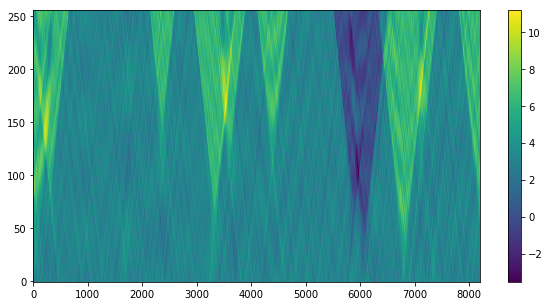

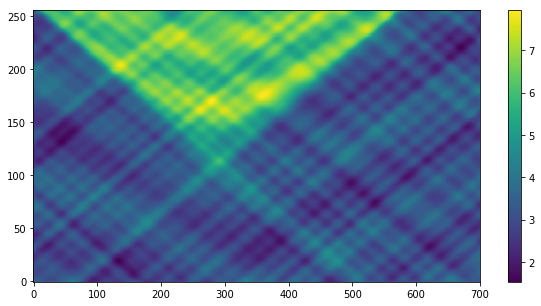

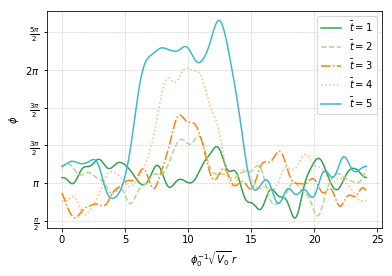

In [14]:
sim = 3
all_data = [np.reshape(np.genfromtxt(sim_location(sim)), (nTime, nLat))]
plot_data_from_files(0)
all_data = [[slice[4100:4800] for slice in simulation] for simulation in all_data]
#all_data = [[2*np.pi-slice for slice in simulation] for simulation in all_data]
plot_data_from_files(0)
plot_slices(0, 75, 191, 25, 39.39920611359256/4.)

[4.759673735059503, 4.861241173200842, 4.962808611342181]
[4.48464151 4.76614382 5.04764612]


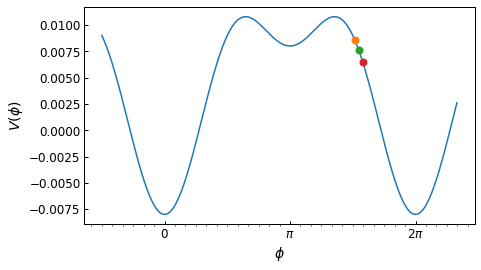

In [35]:
def V(phi, lamb=1.5):
    return ( -np.cos(phi) + 0.5 * lamb**2 * np.sin(phi)**2 ) * 4 * nu
right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')

list_multiplier, list_threshold= [], []
list_type = ['++', '--', '++--', '+-', '-+']
thcorr = ['++', 'foo', '++--', '+-', 'foo']
list_title_type = [r'$\xi^{++}_{bb}(\bar{r},\bar{t})$', r'$\xi^{--}_{bb}(\bar{r},\bar{t})$', r'$\xi^{overall}_{bb}(\bar{r},\bar{t})$', r'$\xi^{+-}_{bb}(\bar{r},\bar{t})$', r'$\xi^{-+}_{bb}(\bar{r},\bar{t})$']

list_phi0 = [2*np.pi/6.6, 2*np.pi/7., 2*np.pi/6.6][::]
list_lamb = [1.5, 1.5, 1.6][::]
filter_size1 = 50.64719566216843/2.
#filter_size1 = 51.46399881629844
filter_size2 = 11.768329733973772
list_filter = [filter_size1, filter_size2]

list_multiplier, list_threshold= [], []
for multiplier in [0.25, 0.3, 0.35]:
    threshold = right_phi_at_V_max.x + np.abs(right_phi_at_V_max.x-2*phi_initial)*multiplier
    list_multiplier.append(multiplier)
    list_threshold.append(threshold)
print(list_threshold)
sigma0 = 0.360805
print((np.asarray(list_threshold)-np.pi)/sigma0)

fig, ax = plt.subplots(figsize=(7,4))
plt.plot([i for i in np.arange(-np.pi/2, 2*phi_initial+np.pi/3, phi_initial/100)], [V(i) for i in np.arange(-np.pi/2, 2*phi_initial+np.pi/3, phi_initial/100)])
[plt.plot(i, V(i), 'o', ms = 7) for i in list_threshold]
ax.tick_params(direction='in', width='1')
plt.xlabel(r'$\phi$', fontsize=14); plt.ylabel(r'$V(\phi)$', fontsize=14)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
plt.tick_params(axis='x', which='both', top=False)
plt.tick_params(direction='in', width='1')
plt.show()

## Animations 

In [ ]:
def animate_field(sim, min, max, step):
    tableau = all_data[sim][0]
    fig = plt.figure()
    camera = Camera(fig)
    for i in range(int(min), int(max), step):
        t = plt.plot(tableau[i])
#        if i*dtout>nLat-mean1:
#            plt.plot(nLat-i*dtout-mean1, np.mean(tableau[i]), 's', color='lime')
#        else:
#            plt.plot(i*dtout+mean1, np.mean(tableau[i]), 's', color='lime')            
        plt.legend(t, [f't = {i}']); plt.grid()
        camera.snap()
    animation = camera.animate(interval = 1);
    animation.save(file_plots + 'bubble_animation.gif', writer = 'imagemagick');
    return

def animate_potential(x, y, lag, sim, max):
    field = simulation(2, x, y, lag, sim)
    potential = simulation(4, x, y, lag, sim)
    fig = plt.figure()
    camera = Camera(fig)
    for i in range(0, int(max), 1):
        plt.plot(field[0], potential[0], 'go')
        plt.plot(np.mean(field[0]), np.mean(potential[0]), 's', color='lime')

        t = plt.plot(field[i], potential[i], 'ro')
        plt.plot(np.mean(field[i]), np.mean(potential[i]), 'v', color='orange')

        plt.title('wid = {:.3f}'.format(x)+', amp = {:.3f}'.format(y)+', lag = '+str(lag)+', sim = '+str(sim))
        plt.plot(xlabel=titles[2], ylabel=titles[4])
        plt.legend(t, [f't = {i}']); plt.grid()
        camera.snap()
    animation = camera.animate(interval = 1);
    animation.save(file_plots + 'alph_potential_animation_'+sim_suffix(4, x, y, lag, sim)+'.gif', writer = 'imagemagick');

In [ ]:
sim = 0
animate_field(sim, 3500, 4500, 5);
#animate_potential(x, y, l, sim, nTime);